# Building your own ETF

In [1]:
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# DOW 30
symbols = ["AXP", "AAPL", "BA", "CAT", "CSCO", "CVX", "XOM", "GS", "HD", "IBM", 
           "INTC", "JNJ", "KO", "JPM", "MCD", "MMM", "MRK", "MSFT", "NKE", "PFE", 
           "PG", "TRV", "UHN", "RTX", "VZ", "V", "WBA", "WMT", "DIS", "DOW"]

In [3]:
stocks = [yf.Ticker(s) for s in symbols]

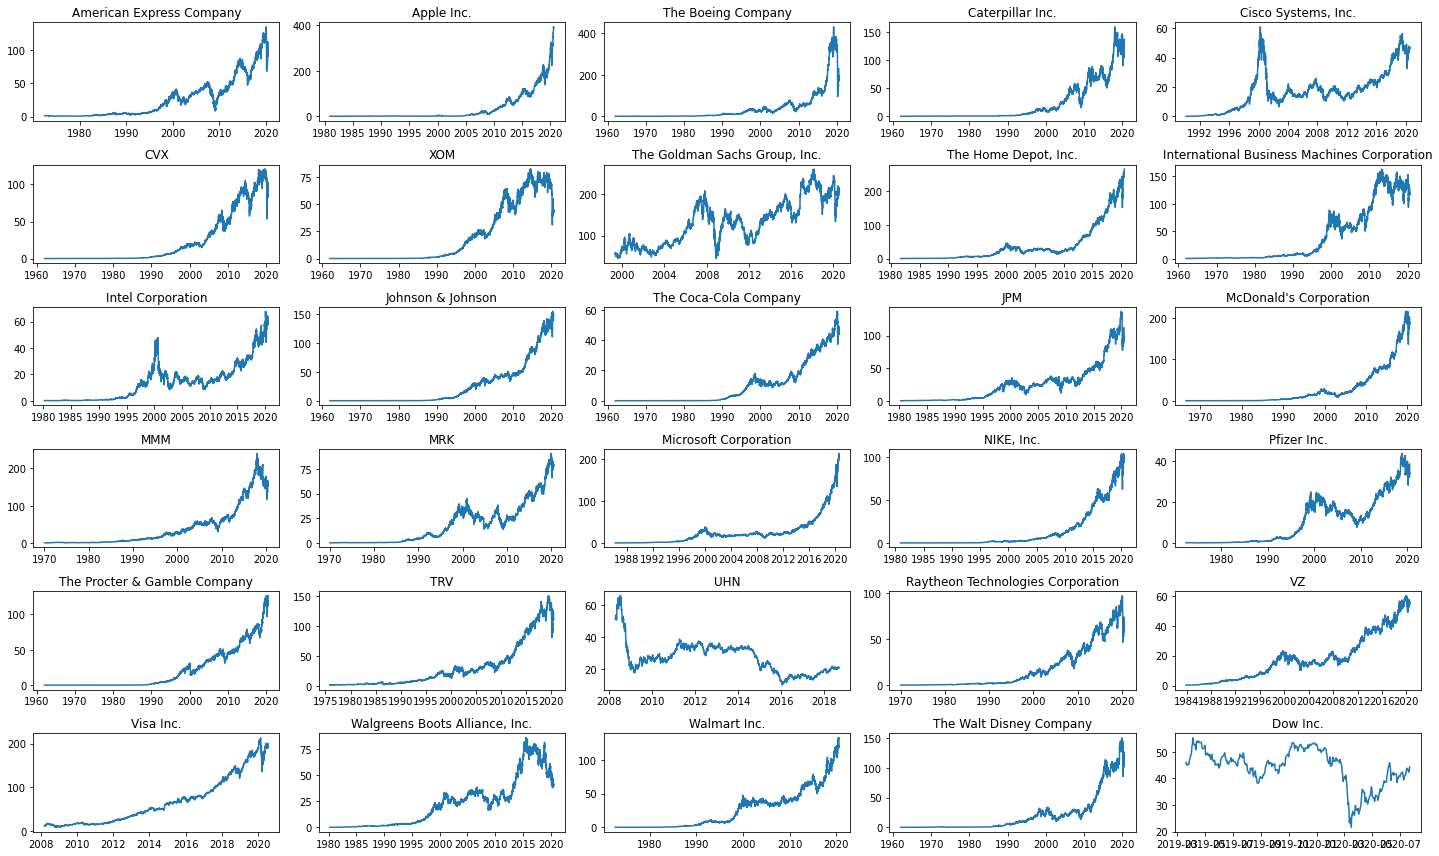

In [4]:
# VIEW
ROWS = 5
COLUMNS = 6

fig, ax = plt.subplots(COLUMNS, ROWS, figsize=(20,12))

for i in range(COLUMNS):
    for j in range(ROWS):
        stock = stocks[i*ROWS+j]
        hist = stock.history(period="max")
        ax[i, j].plot(stock.history(period="max").index, stock.history(period="max")["Close"])
        try:
            ax[i, j].set_title(stock.info["longName"])
        except:
            ax[i, j].set_title(symbols[i*ROWS+j])

fig.tight_layout()
plt.show()

## Market cap and weighting

First we find the individual component market caps along with the total market cap of the index in order to find the correct weighting of each individual stock to make an ETF that reflects the actual index in a proper manner.

\begin{equation*}
Weighting = \frac{Market\;cap\;of\;individual\;component}{The\;total\;market\;cap\;of\;all\;index\;stocks}
\end{equation*}

In [5]:
def get_stock_market_caps_as_dict(symbols, stocks):
    market_caps = {}

    for sy, st in zip(symbols, stocks):
        try:
            market_caps[sy] = st.info["marketCap"]
        except:
            print(sy + ":", "No market cap info")
    return market_caps
            
market_caps = get_stock_market_caps_as_dict(symbols, stocks)

CVX: No market cap info
XOM: No market cap info
JPM: No market cap info
MMM: No market cap info
MRK: No market cap info
TRV: No market cap info
UHN: No market cap info
VZ: No market cap info


Some stocks might be missing their market cap into, so these are added manualy

NOTE: These will have to be updated manually over time

In [6]:
market_caps["CVX"] = 169.97 * 10 ** 9
market_caps["XOM"] = 184.39 * 10 ** 9
market_caps["JPM"] = 300.71 * 10 ** 9
market_caps["MMM"] = 91.29 * 10 ** 9
market_caps["MRK"] = 198.85 * 10 ** 9
market_caps["TRV"] = 30.91 * 10 ** 9
market_caps["UHN"] = 289.36 * 10 ** 9
market_caps["VZ"] = 230.69 * 10 ** 9

In [7]:
print(len(market_caps))

30


In [8]:
total_index_market_cap = sum(market_caps.values())
print("Total index market cap:", total_index_market_cap / 10 ** 9, "billions")

Total index market cap: 8592.184979072 billions


In [9]:
def get_sorted_stock_weightings_as_dict(market_caps, total_index_market_cap):
    weightings = {}
    for sy, val in market_caps.items():
        weightings[sy] = val / total_index_market_cap
    
    return {k: v for k, v in sorted(weightings.items(), key=lambda item: item[1], reverse=True)}

stock_weightings = get_sorted_stock_weightings_as_dict(market_caps, total_index_market_cap)

In [10]:
stock_weightings

{'AAPL': 0.1962765519722487,
 'MSFT': 0.18688998823270608,
 'V': 0.050838510879357035,
 'JNJ': 0.04602773659683404,
 'WMT': 0.04372420951958789,
 'PG': 0.03634433366141607,
 'JPM': 0.03499808264515253,
 'UHN': 0.03367711480895659,
 'HD': 0.03319244942964468,
 'INTC': 0.030083812534948216,
 'VZ': 0.026848816751721714,
 'DIS': 0.025022775752113886,
 'PFE': 0.024928960684355992,
 'KO': 0.024233214382040506,
 'MRK': 0.023143123720490107,
 'CSCO': 0.023047207647685888,
 'XOM': 0.02146019905869334,
 'CVX': 0.019781929790151892,
 'NKE': 0.017900921363149244,
 'MCD': 0.017188303260197123,
 'IBM': 0.01329639187683539,
 'BA': 0.011808403174643732,
 'RTX': 0.011220618853391205,
 'MMM': 0.010624771256945144,
 'AXP': 0.00904449789725003,
 'CAT': 0.008628644623059243,
 'GS': 0.008244785416113232,
 'WBA': 0.004103644091215572,
 'DOW': 0.003822544981049433,
 'TRV': 0.0035974551380455076}

## How many to buy?

Finally we need to figure out the amount of each stock we have to (and are able to) buy in order to stay as close to the accurate weighting as possible.

\begin{equation*}
Amount\;to\;buy = \frac{Weightings*Total\;amount\;to\;invest\;for}{Current\;price\;of\;the\;stock}
\end{equation*}

In [11]:
AMOUNT_TO_INVEST_FOR = 1000000 # USD

def get_number_of_stocks_to_buy_as_dict(stock_weightings, total_amount_to_invest_for):
    number_of_stocks = {}
    
    for sy, val in stock_weightings.items():
        amount_to_invest_for = total_amount_to_invest_for * val
        stock = yf.Ticker(sy)
        try:
            current_price = stock.history(period="1")["Close"].item()
            number_of_stocks[sy] = int(amount_to_invest_for // current_price)
        except:
            print("No data for", sy)
    
    return number_of_stocks
        
number_of_stocks_to_buy = get_number_of_stocks_to_buy_as_dict(stock_weightings, AMOUNT_TO_INVEST_FOR)

- UHN: No data found for this date range, symbol may be delisted
No data for UHN


Some stocks might be missing the necessary data, so these are added manualy

NOTE: These will have to be updated manually over time

In [12]:
number_of_stocks_to_buy["UHN"] = int((stock_weightings["UHN"] * AMOUNT_TO_INVEST_FOR) // 305.11)

In [13]:
number_of_stocks_to_buy 

{'AAPL': 504,
 'MSFT': 882,
 'V': 255,
 'JNJ': 306,
 'WMT': 329,
 'PG': 288,
 'JPM': 354,
 'HD': 125,
 'INTC': 492,
 'VZ': 481,
 'DIS': 210,
 'PFE': 646,
 'KO': 499,
 'MRK': 293,
 'CSCO': 491,
 'XOM': 492,
 'CVX': 217,
 'NKE': 180,
 'MCD': 86,
 'IBM': 103,
 'BA': 65,
 'RTX': 176,
 'MMM': 66,
 'AXP': 93,
 'CAT': 62,
 'GS': 40,
 'WBA': 100,
 'DOW': 86,
 'TRV': 29,
 'UHN': 110}

Now we know how many of each stock, we have to buy in order to get a pretty accurate representation of the volatility of the actual index. We have our ETF!

NOTE: This final step can be futher refined so that we spend all our money. See if you can figure out how.